# CNN + GlobalAvgPool 
Based on CNN 107 which got 75% acc on H1 coding len 2000-4000.  
Model: Embed mask, Conv1D, GlobalAvgPool.   

H1 coding len 3000-4000.  
Cross validation 5 folds 5 epochs, accuracy mean , F1 mean 

Same as CNN 118 but switch cell line 1 to 13.   


In [307]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-12-29 16:52:18.672605
Python 3.8.16
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [308]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import Flatten
from keras.layers import Attention
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
CFILTERS=64
FILTERSIZE=8
RCELLS=16
DCELLS=8
EPOCHS=5
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=3000
MAXLEN=4000   

In [309]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/


In [310]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [311]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
CELL_LINE_NUMBER=13

all_cell_lines = get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 13 = K562


## Data Load

In [312]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields[0]
                    rci_val = fields[cell_line+1]
                    if rci_val != "nan":
                        # Convert string nan to float(nan)
                        gene_to_rci[gene_id] = float(rci_val)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [313]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE_NUMBER)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2022-12-29 16:52:21.405549
Load RCI values...
Num RCI: 6676
Example RCI: [('ENSG00000000457', -0.974177), ('ENSG00000000460', -0.615989), ('ENSG00000001084', -0.745669)]
Load genes...
2022-12-29 16:52:21.433665
Load sequence...
2022-12-29 16:52:28.135735
Num IDs: 3948
Example IDs: [('ENSG00000007923', 'ENST00000377577.10'), ('ENSG00000048707', 'ENST00000543766.2'), ('ENSG00000055070', 'ENST00000401088.9'), ('ENSG00000076864', 'ENST00000374761.6')]
Count 1440 ones out of 3948 labels.
Example labels: [0, 0, 1, 0]
Num counts: 3948
Example sequence: [4, 14, 54, 214, 86, 86, 85, 81, 67, 12, 48, 190, 248, 222, 117, 212, 79, 57, 228, 142, 54, 216, 96, 127, 250, 232, 160, 126, 246, 214, 88, 96, 128, 254, 246, 213, 83, 76, 46, 181, 210, 70, 22, 88, 96, 127, 251, 236, 175, 186, 230, 150, 88, 95, 124, 237, 178, 200, 32, 126, 245, 210, 72, 31, 124, 239, 187, 236, 174, 182, 216, 95, 121, 225, 130, 8, 31, 121, 225, 131, 9, 35, 138, 40, 159, 124, 239, 188, 240, 192, 256, 256, 254, 245, 211, 75, 41, 1

## Model

In [314]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    #rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=False) )
    #pool_layer = MaxPooling1D(pool_size=3)
    pool_layer = GlobalAveragePooling1D()
    #pool_layer = GlobalMaxPooling1D()
    flat_layer = Flatten()
    den1_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    rnn.add(embed_layer)
    rnn.add(cnn1_layer)
    rnn.add(pool_layer)
    #rnn.add(flat_layer)
    #rnn.add(den1_layer)
    #rnn.add(drop_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [315]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2022-12-29 16:52:28.163614
COMPILE
Model: "sequential_160"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_160 (Embedding)   (None, 3997, 4)           1028      
                                                                 
 conv1d_160 (Conv1D)         (None, 3990, 64)          2112      
                                                                 
 global_average_pooling1d_14  (None, 64)               0         
 7 (GlobalAveragePooling1D)                                      
                                                                 
 dense_319 (Dense)           (None, 1)                 65        
                                                                 
Total params: 3,205
Trainable params: 3,205
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [316]:
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,pred_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = pred_threshold # e.g. score>0.5 => class 1
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        for train_index,valid_index in splitter.split(all_genes):
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print('Train sizes',X_train.shape,y_train.shape)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                    validation_data=(X_valid,y_valid) )

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print("Compute valiation accuracy")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

2022-12-29 16:52:28.461805
2022-12-29 16:52:28.463818
splitting
Fold 1
Training example
[ 33 131  10 ...   0   0   0]
Train sizes (3095, 3997) (3095, 1)
Valid sizes (853, 3997) (853, 1)
Train set ones/size 1107 / 3095
Valid set ones/size 333 / 853
BUILD MODEL
COMPILE
FIT
2022-12-29 16:52:29.450309
Epoch 1/5
97/97 [==============================] - 2s 10ms/step - loss: 0.6543 - accuracy: 0.6417 - val_loss: 0.6627 - val_accuracy: 0.6096
Epoch 2/5
97/97 [==============================] - 1s 7ms/step - loss: 0.6356 - accuracy: 0.6426 - val_loss: 0.6402 - val_accuracy: 0.6108
Epoch 3/5
97/97 [==============================] - 1s 8ms/step - loss: 0.6231 - accuracy: 0.6520 - val_loss: 0.6247 - val_accuracy: 0.6448
Epoch 4/5
97/97 [==============================] - 1s 8ms/step - loss: 0.6171 - accuracy: 0.6620 - val_loss: 0.6193 - val_accuracy: 0.6495
Epoch 5/5
97/97 [==============================] - 1s 7ms/step - loss: 0.6094 - accuracy: 0.6675 - val_loss: 0.6269 - val_accuracy: 0.6331


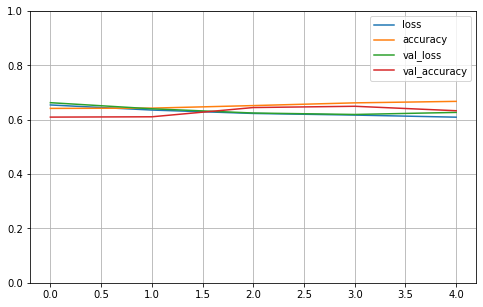

Compute valiation accuracy
2022-12-29 16:52:34.619710
Range of scores: 0.051057283 to 0.70610183
Predicted zeros and ones 791 62
Accuracy: 63.31% Precision: 66.13% Recall: 12.31% F1: 20.76%
2022-12-29 16:52:34.814979
Fold 2
Training example
[ 33 131  10 ...   0   0   0]
Train sizes (3149, 3997) (3149, 1)
Valid sizes (799, 3997) (799, 1)
Train set ones/size 1204 / 3149
Valid set ones/size 236 / 799
BUILD MODEL
COMPILE
FIT
2022-12-29 16:52:35.763279
Epoch 1/5
99/99 [==============================] - 2s 10ms/step - loss: 0.6636 - accuracy: 0.6183 - val_loss: 0.6095 - val_accuracy: 0.7046
Epoch 2/5
99/99 [==============================] - 1s 8ms/step - loss: 0.6394 - accuracy: 0.6237 - val_loss: 0.6148 - val_accuracy: 0.6746
Epoch 3/5
99/99 [==============================] - 1s 7ms/step - loss: 0.6316 - accuracy: 0.6304 - val_loss: 0.6144 - val_accuracy: 0.6671
Epoch 4/5
99/99 [==============================] - 1s 7ms/step - loss: 0.6215 - accuracy: 0.6424 - val_loss: 0.5977 - val_accuracy

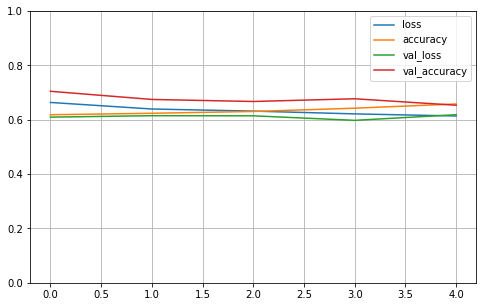

Compute valiation accuracy
2022-12-29 16:52:40.525456
Range of scores: 0.14309247 to 0.8087808
Predicted zeros and ones 532 267
Accuracy: 65.33% Precision: 42.32% Recall: 47.88% F1: 44.93%
2022-12-29 16:52:40.774374
Fold 3
Training example
[ 33 131  10 ...   0   0   0]
Train sizes (3169, 3997) (3169, 1)
Valid sizes (779, 3997) (779, 1)
Train set ones/size 1161 / 3169
Valid set ones/size 279 / 779
BUILD MODEL
COMPILE
FIT
2022-12-29 16:52:41.764161
Epoch 1/5
100/100 [==============================] - 2s 10ms/step - loss: 0.6595 - accuracy: 0.6336 - val_loss: 0.6434 - val_accuracy: 0.6418
Epoch 2/5
100/100 [==============================] - 1s 8ms/step - loss: 0.6375 - accuracy: 0.6343 - val_loss: 0.6330 - val_accuracy: 0.6457
Epoch 3/5
100/100 [==============================] - 1s 8ms/step - loss: 0.6222 - accuracy: 0.6504 - val_loss: 0.6374 - val_accuracy: 0.6098
Epoch 4/5
100/100 [==============================] - 1s 8ms/step - loss: 0.6126 - accuracy: 0.6589 - val_loss: 0.6277 - val_a

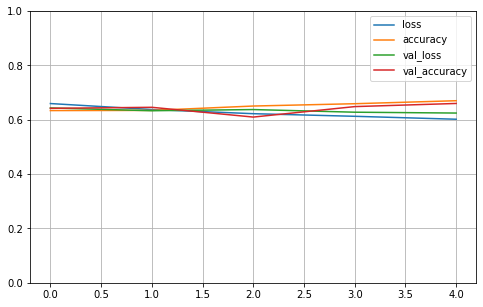

Compute valiation accuracy
2022-12-29 16:52:46.799927
Range of scores: 0.080362506 to 0.78946614
Predicted zeros and ones 643 136
Accuracy: 65.98% Precision: 55.15% Recall: 26.88% F1: 36.14%
2022-12-29 16:52:46.967078
Fold 4
Training example
[ 47 187 235 ...   0   0   0]
Train sizes (3186, 3997) (3186, 1)
Valid sizes (762, 3997) (762, 1)
Train set ones/size 1146 / 3186
Valid set ones/size 294 / 762
BUILD MODEL
COMPILE
FIT
2022-12-29 16:52:47.906665
Epoch 1/5
100/100 [==============================] - 2s 10ms/step - loss: 0.6571 - accuracy: 0.6353 - val_loss: 0.6605 - val_accuracy: 0.6142
Epoch 2/5
100/100 [==============================] - 1s 7ms/step - loss: 0.6356 - accuracy: 0.6403 - val_loss: 0.6497 - val_accuracy: 0.6115
Epoch 3/5
100/100 [==============================] - 1s 7ms/step - loss: 0.6209 - accuracy: 0.6557 - val_loss: 0.6439 - val_accuracy: 0.6391
Epoch 4/5
100/100 [==============================] - 1s 8ms/step - loss: 0.6120 - accuracy: 0.6585 - val_loss: 0.6387 - val

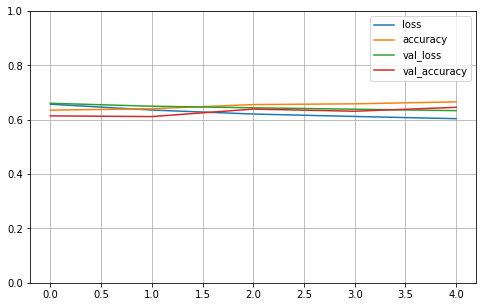

Compute valiation accuracy
2022-12-29 16:52:52.670483
Range of scores: 0.09541986 to 0.7473999
Predicted zeros and ones 576 186
Accuracy: 64.57% Precision: 56.45% Recall: 35.71% F1: 43.75%
2022-12-29 16:52:52.839206
Fold 5
Training example
[ 33 131  10 ...   0   0   0]
Train sizes (3193, 3997) (3193, 1)
Valid sizes (755, 3997) (755, 1)
Train set ones/size 1142 / 3193
Valid set ones/size 298 / 755
BUILD MODEL
COMPILE
FIT
2022-12-29 16:52:53.818043
Epoch 1/5
100/100 [==============================] - 2s 10ms/step - loss: 0.6547 - accuracy: 0.6420 - val_loss: 0.6648 - val_accuracy: 0.6053
Epoch 2/5
100/100 [==============================] - 1s 7ms/step - loss: 0.6372 - accuracy: 0.6430 - val_loss: 0.6348 - val_accuracy: 0.6066
Epoch 3/5
100/100 [==============================] - 1s 8ms/step - loss: 0.6256 - accuracy: 0.6474 - val_loss: 0.6179 - val_accuracy: 0.6437
Epoch 4/5
100/100 [==============================] - 1s 8ms/step - loss: 0.6197 - accuracy: 0.6555 - val_loss: 0.6122 - val_a

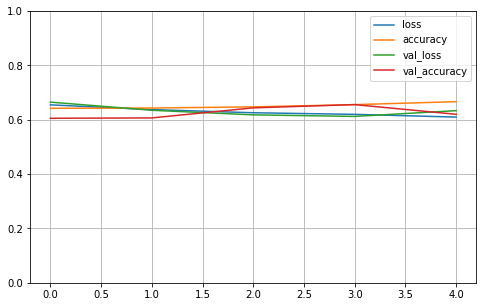

Compute valiation accuracy
2022-12-29 16:52:59.708994
Range of scores: 0.09066963 to 0.632617
Predicted zeros and ones 722 33
Accuracy: 61.99% Precision: 66.67% Recall: 7.38% F1: 13.29%
2022-12-29 16:52:59.872024

Cross validation 5 folds 5 epochs
 accuracy mean 64.23% +/- 1.43
 precision mean 57.34% +/- 8.89
 recall mean 26.03% +/- 14.89
 F1 mean 31.78% +/- 12.64
2022-12-29 16:52:59.874140


In [317]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(datetime.now())